# Estimating Retaliation Probability
## In the Russo-Ukraine War



In [146]:
import pandas as pd
import spacy
from nltk.corpus import stopwords
from spacy.matcher import Matcher
stopwords = stopwords.words('english')
nlp = spacy.load("en_core_web_sm")
from collections import Counter
import matplotlib.pyplot as plt
%run ./hmm_logic/hidden_markov_model.ipynb

In [147]:
df = pd.read_csv('time_series_ISW.csv')

In [24]:
# stopwords removal and making text lowercase
def stopword_remove(text):
    text = text.lower()
    stopewords_removed_text = ' '.join([word for word in text.split() if word not in stopwords])
    return stopewords_removed_text

df.article = df.article.apply(lambda x: stopword_remove(x))

In [4]:
df.article.head(10)

0    note: data cut-off product 1pm et august 17. i...
1    ukrainian forces continued marginally advance ...
2    note: data cut-off product 12:30pm et august 1...
3    note: data cut-off product 2:00pm et august 14...
4    ukrainian president volodymyr zelensky senior ...
5    note: data cut-off product 1pm et august 12. i...
6    ukraine's operation kursk oblast allowed ukrai...
7    russian national antiterrorism committee annou...
8    russian sources claimed august 9 ukrainian for...
9    data cut-off product 2:45pm et august 8. isw c...
Name: article, dtype: object

## Imputation to Russian Forces


In [5]:
russian_attack_matcher = Matcher(nlp.vocab)
ukraine_attack_matcher = Matcher(nlp.vocab)

russian_attack = [
    {'LOWER': {'IN': ['russia', 'russian']}, 'DEP': {'IN': ['nsubj', 'amod']}},
    {'LEMMA': {'IN': ['military', 'force', 'army', 'troops', 'missile']}, 'DEP': 'nsubj'},
    {'LEMMA': {'IN':['attack', 'strike', 'damage', 'destroy', 'kill', 'cut']}},   
]


ukraine_attack = [
        {'LOWER': {'IN': ['ukraine', 'ukrainian']}, 'DEP': {'IN': ['nsubj', 'amod']}},
        {'LEMMA': {'IN': ['military', 'force', 'army', 'troops', 'missile']}, 'DEP': 'nsubj'},
        {'LEMMA': {'IN':['attack', 'strike', 'damage', 'destroy', 'kill', 'cut']}},   
]


russian_attack_matcher.add('RussianAttack', patterns=[russian_attack])
ukraine_attack_matcher.add('UkraineAttack', patterns=[ukraine_attack])

In [6]:
russian_attack_spans = []
def attack_pattern_finder(text):
    doc = nlp(text)
    matches = russian_attack_matcher(doc)
    
    for match_id, start, end in matches:
        if nlp.vocab.strings[match_id] == 'RussianAttack':
            span = doc[start:end]
            russian_attack_spans.append(span.sent)
        return 1
    return 0

df['russia_attacks'] = df.article.apply(lambda x: attack_pattern_finder(x))

In [7]:
ukraine_attack_span = []

def attack_pattern_finder(text):
    doc = nlp(text)
    matches = ukraine_attack_matcher(doc)
    
    for match_id, start, end in matches:
        if nlp.vocab.strings[match_id] == 'UkraineAttack':
            span = doc[start:end]
            ukraine_attack_span.append(span.sent)
        return 1
    return 0

df['ukraine_attacks'] = df.article.apply(lambda x: attack_pattern_finder(x))

In [8]:
df['attacks_tuple'] = df.apply(lambda row: (row['russia_attacks'], row['ukraine_attacks']), axis=1)

In [9]:
df

,Date,article,russia_attacks,ukraine_attacks,attacks_tuple
0,08-17-24,note: data cut-off product 1pm et august 17. i...,1,0,"(1, 0)"
1,08-16-24,ukrainian forces continued marginally advance ...,1,0,"(1, 0)"
2,08-15-24,note: data cut-off product 12:30pm et august 1...,0,0,"(0, 0)"
3,08-14-24,note: data cut-off product 2:00pm et august 14...,0,0,"(0, 0)"
4,08-13-24,ukrainian president volodymyr zelensky senior ...,0,0,"(0, 0)"
...,...,...,...,...,...
212,01-07-24,note: data cut-off product 2:00pm et january 7...,1,1,"(1, 1)"
213,01-05-24,correction: isw inaccurately stated google's 4...,0,1,"(0, 1)"
214,01-04-24,note: data cut-off product 12:10pm et january ...,0,1,"(0, 1)"
215,01-03-24,note: data cut-off product 12:15 pm et january...,0,0,"(0, 0)"


In [34]:
tuple_to_index = {(0, 0): 0, (0, 1): 1, (1, 0): 2, (1, 1): 3}
indexed_observations = np.array([tuple_to_index[obs] for obs in df['attacks_tuple']])

transition_probabilities = np.array([[0.3, 0.7], [0.2, 0.8]])

# Emission probabilities:
# State 0: Low retaliation (more likely to see (0,0), (0,1), or (1,0) and less likely to see (1,1))
# State 1: High retaliation (more likely to see (1,1))
emission_probabilities = np.array([[0.4, 0.3, 0.2, 0.1],  # State 0: Low retaliation
                                   [0.1, 0.2, 0.2, 0.5]]) # State 1: High retaliation


# Note that the order is not important in this case since it was not checked the priority of an event over another

In [35]:
most_likely_states_sequence, most_likely_states = forward_back(indexed_observations, transition_probabilities, emission_probabilities)

/tmp/ipykernel_4354/4253867206.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_steps = pd.to_datetime(df.Date)


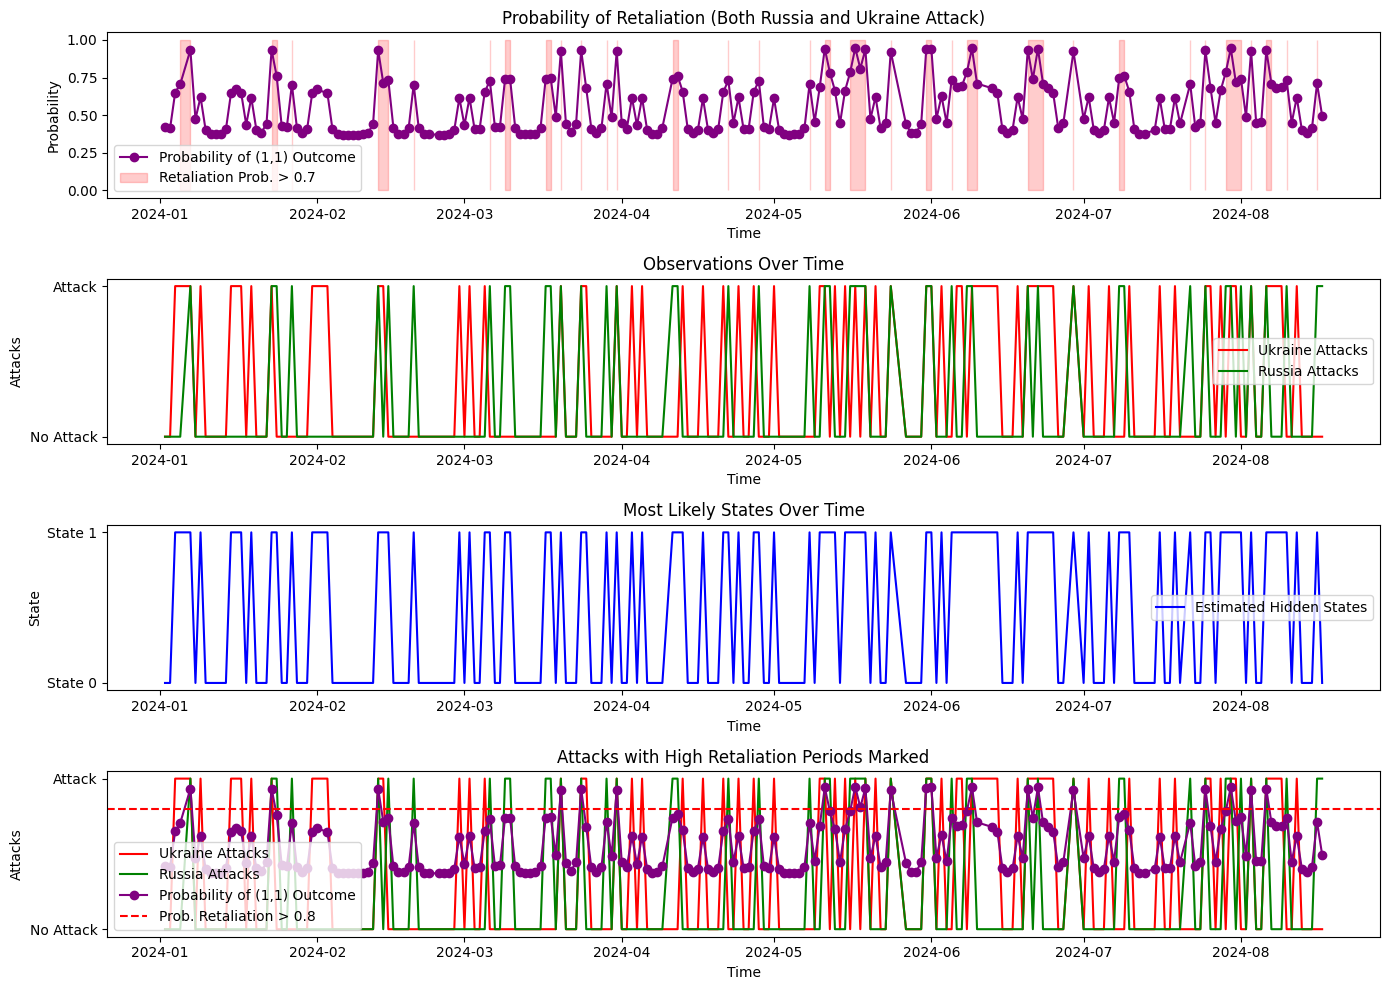

In [47]:
most_likely_states_sequence, most_likely_states = forward_back(indexed_observations, transition_probabilities, emission_probabilities)

probability_of_high_retaliation = most_likely_states[:, 1] 
high_prob_indices = np.where(most_likely_states[:, 1] > 0.70)[0]



time_steps = pd.to_datetime(df.Date)

plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(time_steps, probability_of_high_retaliation, marker='o', linestyle='-', color='purple', label='Probability of (1,1) Outcome')
plt.fill_between(time_steps, 0, 1, where=probability_of_high_retaliation > 0.7, color='red', alpha=0.2, label='Retaliation Prob. > 0.7')
plt.title('Probability of Retaliation (Both Russia and Ukraine Attack)')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()


plt.subplot(4, 1, 2)
plt.plot(time_steps, df['ukraine_attacks'], linestyle='-', color='red', label='Ukraine Attacks')
plt.plot(time_steps, df['russia_attacks'], linestyle='-', color='green', label='Russia Attacks')
plt.title('Observations Over Time')
plt.xlabel('Time')
plt.ylabel('Attacks')
plt.yticks([0, 1], ['No Attack', 'Attack'])
plt.legend()


plt.subplot(4, 1, 3)
plt.plot(time_steps, most_likely_states_sequence, linestyle='-', color='blue', label='Estimated Hidden States')
plt.title('Most Likely States Over Time')
plt.xlabel('Time')
plt.ylabel('State')
plt.yticks([0, 1], ['State 0', 'State 1'])
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(time_steps, df['ukraine_attacks'], linestyle='-', color='red', label='Ukraine Attacks')
plt.plot(time_steps, df['russia_attacks'], linestyle='-', color='green', label='Russia Attacks')
plt.plot(time_steps, probability_of_high_retaliation, marker='o', linestyle='-', color='purple', label='Probability of (1,1) Outcome')
plt.axhline(0.8, color='red', linestyle='--', label='Prob. Retaliation > 0.8 ')
plt.title('Attacks with High Retaliation Periods Marked')
plt.xlabel('Time')
plt.ylabel('Attacks')
plt.yticks([0, 1], ['No Attack', 'Attack'])
plt.legend(loc='lower left')

plt.tight_layout()
#plt.savefig('RussoUkraineWar_Hmm.png')
plt.show()
